# Loan credibility prediction 
Problem statement: 

Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan. 

The company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

<a href="https://www.kaggle.com/datasets/burak3ergun/loan-data-set">Source</a>

## Possible solutions
- Decision trees
- Random forest
- And several others...

# Data exploration

Let's see what we have.

In [117]:
import pandas as pd
import numpy as np

In [118]:
raw = pd.read_csv('loan_data_set.csv')
raw.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [119]:
orig_len = raw.shape[0]
orig_len

614

In [120]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Check for null values in dataset

In [121]:
raw.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

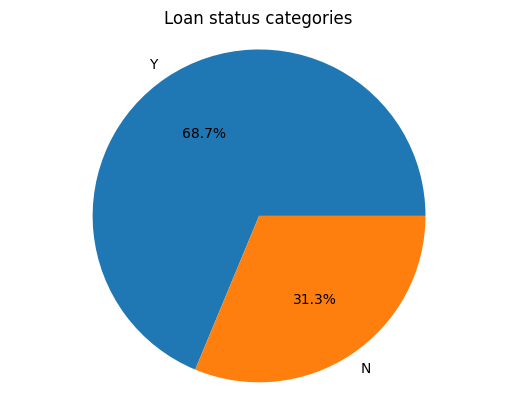

In [122]:
import matplotlib.pyplot as plt

categories_plot = raw['Loan_Status'].value_counts()
plt.pie(categories_plot, labels=categories_plot.index, autopct='%1.1f%%' )
plt.title('Loan status categories')
plt.axis('equal')
plt.show()

# Data preparation

#### Handling null values

There are a number of ways we can handle null values. See detailed <a href=https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e>here</a>.

1. Deleting null values
2. Imputing null values with mean/median
3. Imputing null values with the most frequent category

Categorical variables to be dropped (possibly higher importance): Self_Employed, Credit_History, Dependents

Categorical variables to be filled (possibly lower importance): Gender, Married

Continuous variables to be filled with mean/median: LoanAmount, Loan_Amount_Term

In [123]:
discovery = raw.copy()

In [124]:
discovery = discovery.dropna(subset=['Self_Employed', 'Credit_History', 'Dependents'])

In [125]:
for name in ['Gender', 'Married']:
    discovery[name] = discovery[name].fillna(discovery[name].value_counts().idxmax())

In [126]:
for name in ['LoanAmount', 'Loan_Amount_Term']:
    discovery[name] = discovery[name].fillna(discovery[name].mean())

Successfully cleared dataset of null values

In [127]:
discovery.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [128]:
print(f'{raw.shape[0] - discovery.shape[0]} rows deleted, {discovery.shape[0]} rows left')

91 rows deleted, 523 rows left


#### Feature engineering

Create new columns:
- **CollectiveIncome** describing the collective income of the applicant and co-applicant
- **LoanAmountPerIncome** describing the loan amount compared to the collective income of the household
- **MonthlyLoanCost** describing the approximate monthly cost of the loan compared to the collective income of the household

In [129]:
discovery['CollectiveIncome'] = discovery['ApplicantIncome'] + discovery['CoapplicantIncome']
discovery['LoanAmountPerIncome'] = discovery['LoanAmount'] / discovery['CollectiveIncome']
discovery['MonthlyLoanCost'] = (discovery['LoanAmount'] * 30) / (discovery['Loan_Amount_Term'] * discovery['CollectiveIncome'])
discovery.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,CollectiveIncome,LoanAmountPerIncome,MonthlyLoanCost
0,LP001002,Male,No,0,Graduate,No,5849,0.0,145.765873,360.0,1.0,Urban,Y,5849.0,0.024922,0.002077
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0,0.021015,0.001751
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0,0.022000,0.001833
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0,0.024287,0.002024
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0,0.023500,0.001958


**Preparing the data for machine learning algorithms**

X will be a collection of the features, excluding unusable determiners like the ID and the label variable. y will be a series of labels.

In [130]:
X = discovery.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = discovery['Loan_Status']

The next step is one-hot encoding the categorical features to a numerical representation the algorithm can handle.

In [131]:
cat_vars = X.select_dtypes('object').columns.tolist()
X_transformed = pd.get_dummies(X, columns=cat_vars,drop_first=True)
X_transformed.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,CollectiveIncome,LoanAmountPerIncome,MonthlyLoanCost,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,145.765873,360.0,1.0,5849.0,0.024922,0.002077,1,0,0,0,0,0,0,0,1
1,4583,1508.0,128.000000,360.0,1.0,6091.0,0.021015,0.001751,1,1,1,0,0,0,0,0,0
2,3000,0.0,66.000000,360.0,1.0,3000.0,0.022000,0.001833,1,1,0,0,0,0,1,0,1
3,2583,2358.0,120.000000,360.0,1.0,4941.0,0.024287,0.002024,1,1,0,0,0,1,0,0,1
4,6000,0.0,141.000000,360.0,1.0,6000.0,0.023500,0.001958,1,0,0,0,0,0,0,0,1


Splitting data to training and testing batches. The testing batch is used at the end to validate the efficiency of the model.

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.33, random_state=42)

# Quick introduction to Decision Trees

Decision trees follow a top-down approach meaning that the root node of the tree is always at the top of the structure while the outcomes are represented by the tree leaves. Each node following the root node is split into several nodes. The key idea is to use a decision tree to partition the data space into dense regions and sparse regions. The algorithm keeps on splitting the tree until the data is sufficiently homogeneous. At the end of the training, a decision tree is returned that can be used to make optimal categorized predictions.

Advantages of using a decision tree are:
- Extremely fast classification of unknown records
- Disregards features that are of little or no importance in prediction
- Extremely efficient, provided the parameters are tuned optimally
- Inexpensive to construct with an easy to interpret logic

Limitations:
- Decision Tree Classifiers often tend to overfit the training data
- Changes in data may lead to unnecessary changes in the result
- Large trees can sometimes be very difficult to interpret
- These are biased toward splits on features having a number of levels

See further <a href="https://towardsdatascience.com/an-exhaustive-guide-to-classification-using-decision-trees-8d472e77223f">here</a>

# Implementation

Build a simple decision tree with a depth of 5 and fit on training data.

In [133]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=42, max_depth=5)

In [134]:
%%time
clf = clf.fit(X_train, y_train)

CPU times: user 5.01 ms, sys: 7.84 ms, total: 12.8 ms
Wall time: 2.21 ms


Evaluate accuracy on test data.

In [135]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.815028901734104


Visualize tree.

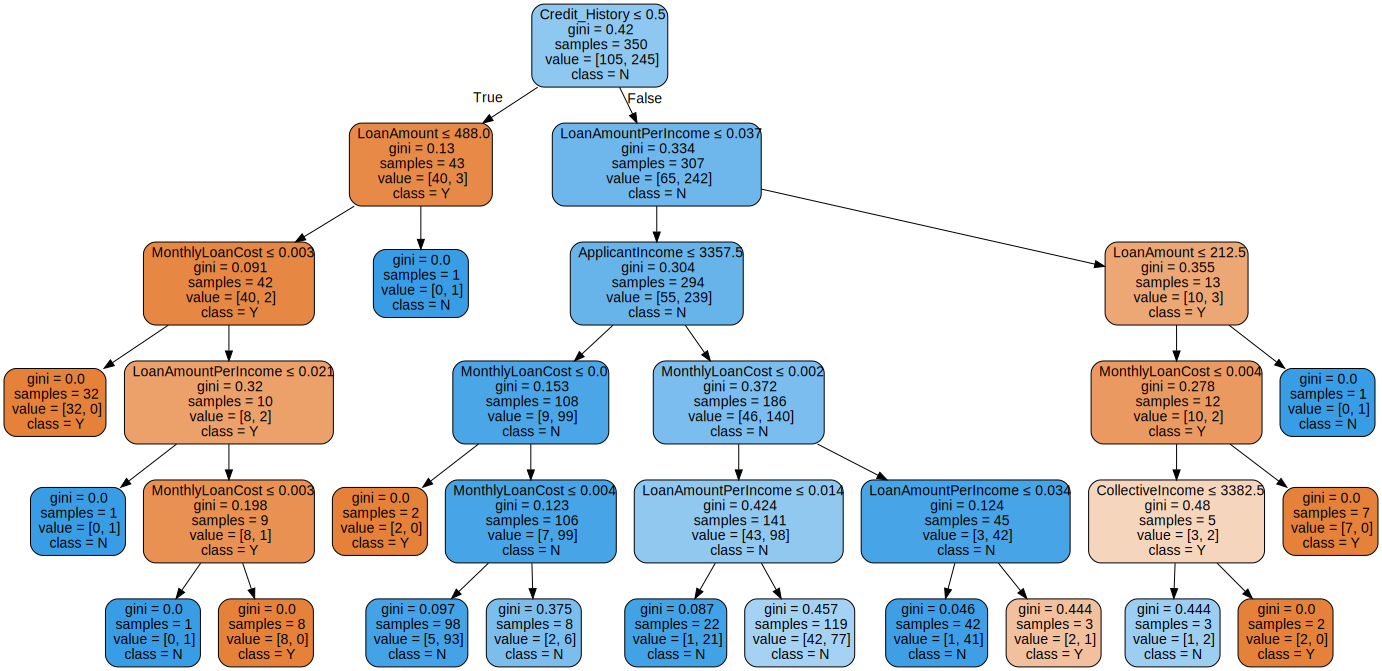

In [136]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X_transformed.columns,  
                     class_names=['Y', 'N'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

# Quick intro to Random Forests
Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction. The reason that the random forest model works so well is that a large number of relatively uncorrelated models operating as a committee will outperform any of the individual constituent models. While some trees may be wrong, many other trees will be right, so as a group the trees are able to move in the correct direction.

Advantages 

1. It solves the problem of overfitting as output is based on majority voting or averaging.

2. Each decision tree created is independent of the other thus it shows the property of parallelization.

3. It is highly stable as the average answers given by a large number of trees are taken.

4. It maintains diversity as all the attributes are not considered while making each decision tree though it is not true in all cases.

5. We don’t have to segregate data into train and test as there will always be 30% of the data which is not seen by the decision tree made out of bootstrap.

Disadvantages

1. Random forest is highly complex when compared to decision trees where decisions can be made by following the path of the tree.

2. Training time is more compared to other models due to its complexity. Whenever it has to make a prediction each decision tree has to generate output for the given input data.


See further <a href="https://towardsdatascience.com/an-exhaustive-guide-to-classification-using-decision-trees-8d472e77223f">here</a> and <a href="https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/">here</a>

# Implementation

Build a simple random forest with a depth of 5 and fit on training data.

In [137]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5)

In [138]:
%%time
rfc.fit(X_train, y_train)

CPU times: user 66.9 ms, sys: 17.4 ms, total: 84.3 ms
Wall time: 64 ms


RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

Evaluate accuracy on test data.

In [139]:
y_pred = rfc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8208092485549133
